In [1]:
import sys
import cv2
import torch
import numpy as np
import torch.nn as nn

import matplotlib.pyplot as plt

sys.path.insert(0, '../ultralytics')

import ultralytics
ultralytics.checks()

from ultralytics.nn.modules.block import *
from ultralytics.nn.modules.conv import *
from ultralytics import YOLO

print(ultralytics.__path__)

Ultralytics 8.3.51 🚀 Python-3.11.7 torch-2.2.2 CPU (Intel Core(TM) i9-9980HK 2.40GHz)
Setup complete ✅ (16 CPUs, 32.0 GB RAM, 814.2/931.5 GB disk)
['/Users/ruslanraupov/projects/labs/yolo/ultralytics/ultralytics']


In [11]:
x = torch.randn(1, 32, 64, 64)
model = BiLevelRoutingAttention(32)
output = model(x)
print(output.shape)

torch.Size([1, 32, 64, 64])


In [10]:
model = YOLO('yolo11-cus.yaml', task='detect', verbose=True)

WARNING ⚠️ no model scale passed. Assuming scale='n'.

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      6640  ultralytics.nn.modules.block.C3k2            [32, 64, 1, False, 0.25]      
  3                  -1  1     36992  ultralytics.nn.modules.conv.Conv             [64, 64, 3, 2]                
  4                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  5                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  6                  -1  1     87040  ultralytics.nn.modules.block.C3k2            [128, 128, 1, True]           
  7                  -1  1    295

  8                  -1  1    346112  ultralytics.nn.modules.block.C3k2            [256, 256, 1, True]           
  9                  -1  1    164608  ultralytics.nn.modules.block.SPPF            [256, 256, 5]                 
 10                  -1  1    265728  ultralytics.nn.modules.block.BiLevelRoutingAttention[256]                         
 11                  -1  1    249728  ultralytics.nn.modules.block.C2PSA           [256, 256, 1]                 
 12                  -1  1         0  ultralytics.nn.modules.conv.SNI              [256, 256, 2]                 
 13             [-1, 6]  1         0  ultralytics.nn.modules.conv.Concat           [1]                           
 14                  -1  1    111296  ultralytics.nn.modules.block.C3k2            [384, 128, 1, False]          
 15                  -1  1         0  ultralytics.nn.modules.conv.SNI              [128, 128, 2]                 
 16             [-1, 4]  1         0  ultralytics.nn.modules.conv.Concat         

In [8]:

class BiFormerBlock(nn.Module):
	def __init__(self, dim, drop_path=0., mlp_ratio=4, mlp_dwconv=False):
		super().__init__()
		self.dwconv = DWConv(3, 3, 1, act=False)
		self.norm1 = nn.LayerNorm(dim, eps=1e-6)
		self.attn = BiLevelRoutingAttention(dim)
		self.norm2 = nn.LayerNorm(dim, eps=1e-6)
		# self.mlp = MLP(4, 2 * dim, dim, num_layers=2)
		self.mlp = nn.Sequential(
				nn.Linear(dim, int(mlp_ratio * dim)),
				DWConv(int(mlp_ratio * dim)) if mlp_dwconv else nn.Identity(),
				nn.GELU(),
				nn.Linear(int(mlp_ratio * dim), dim)
		)
		self.drop_path = DropPath(drop_path) if drop_path > 0.0 else nn.Identity()

	def forward(self, x):
		print(x.shape)
		H, W = 8, 8
		B, L, C = x.shape
		assert L == H * W, "input feature has wrong size"
		
		x = self.norm1(x)
		x = x.view(B, H, W, C)
		x = x.permute(0, 3, 1, 2)
		
		x = self.dwconv(x)
		x = x + self.drop_path(self.attn(self.norm1(x)))  # (N, H, W, C)
		x = x + self.drop_path(self.mlp(self.norm2(x)))  # (N, H, W, C)
		print(x.shape)
		# # permute back
		# x = x.permute(0, 3, 1, 2)  # (N, H, W, C) -> (N, C, H, W)
		# x = x.flatten(2).transpose(1, 2)
		return x

model = BiFormerBlock(128)
x = torch.randn(1, 128, 64, 64)  # Input tensor: (B, C, H, W)
output = model(x)
print(output.shape)

In [ ]:
model.train(data='coco128.yaml', epochs=3)

In [ ]:
model = YOLO("../runs/detect/train/weights/best.pt")

model.predict("bus.jpg", save=True)

In [17]:
!ls ../../datasets/coco128/images/train2017/

000000000009.jpg 000000000154.jpg 000000000370.jpg 000000000529.jpg
000000000025.jpg 000000000164.jpg 000000000382.jpg 000000000531.jpg
000000000030.jpg 000000000165.jpg 000000000384.jpg 000000000532.jpg
000000000034.jpg 000000000192.jpg 000000000387.jpg 000000000536.jpg
000000000036.jpg 000000000194.jpg 000000000389.jpg 000000000540.jpg
000000000042.jpg 000000000196.jpg 000000000394.jpg 000000000542.jpg
000000000049.jpg 000000000201.jpg 000000000395.jpg 000000000544.jpg
000000000061.jpg 000000000208.jpg 000000000397.jpg 000000000560.jpg
000000000064.jpg 000000000241.jpg 000000000400.jpg 000000000562.jpg
000000000071.jpg 000000000247.jpg 000000000404.jpg 000000000564.jpg
000000000072.jpg 000000000250.jpg 000000000415.jpg 000000000569.jpg
000000000073.jpg 000000000257.jpg 000000000419.jpg 000000000572.jpg
000000000074.jpg 000000000260.jpg 000000000428.jpg 000000000575.jpg
000000000077.jpg 000000000263.jpg 000000000431.jpg 000000000581.jpg
000000000078.jpg 000000000283.jpg 000000000436.j

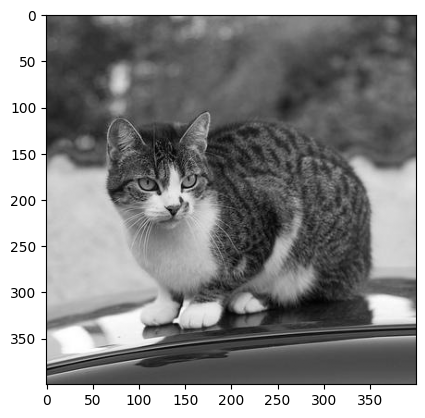

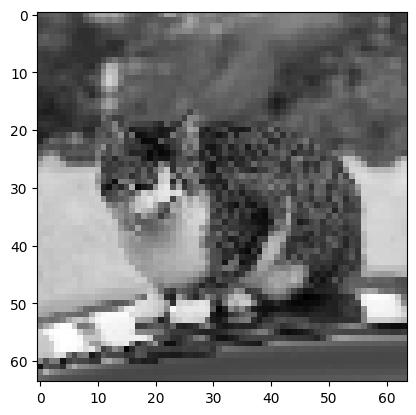

In [57]:
img = cv2.imread('../../datasets/coco128/images/train2017/000000000650.jpg', 0)

crop = img[10:410, 120:520]
resized = cv2.resize(crop, (64,64))
plt.imshow(crop, cmap='gray')
plt.show()

plt.imshow(resized, cmap='gray')
plt.show()

In [80]:
class GSConv(nn.Module):
  """GSConv https://github.com/AlanLi1997/slim-neck-by-gsconv"""
  def __init__(self, c1, c2, k=1, s=1, g=1, act=True):
    """Initializes GSConv module with primary and cheap operations for efficient feature learning."""
    super().__init__()
    c_ = c2 // 2  # hidden channels
    self.cv1 = Conv(c1, c_, k, s, None, g, act=act)
    self.cv2 = Conv(c_, c_, 5, 1, None, c_, act=act)
  
  def forward(self, x):
    """Forward propagation through a GSConv Bottleneck layer with skip connection."""
    x = self.cv1(x)
    x = torch.cat((x, self.cv2(x)), 1)
    
    b, n, h, w = x.data.size()
    b_n = b * n // 2
    
    y = x.reshape(b_n, 2, h * w)
    y = y.permute(1, 0, 2)
    y = y.reshape(2, -1, n // 2, h, w)

    return torch.cat((y[0], y[1]), 1)

# Testing GSConv
if __name__ == "__main__":
  model = GSConv(64, 128)
  x = torch.randn(1, 64, 64, 64)  # Input tensor: (B, C, H, W)
  output = model(x)
  print("Output shape:", output.shape)  # Expected: (1, 128, 64, 64)


Output shape: torch.Size([1, 128, 64, 64])


In [103]:
x = torch.from_numpy(np.array([[crop/255] * 400])).type(torch.float)
x.shape

torch.Size([1, 400, 400, 400])

In [101]:
model = GSConv(64, 128)
output = model(x)
print("Output shape:", output.shape)

Output shape: torch.Size([1, 128, 64, 64])


In [104]:
model = GSConv(400, 800)
output = model(x)
print("Output shape:", output.shape)

Output shape: torch.Size([1, 800, 400, 400])


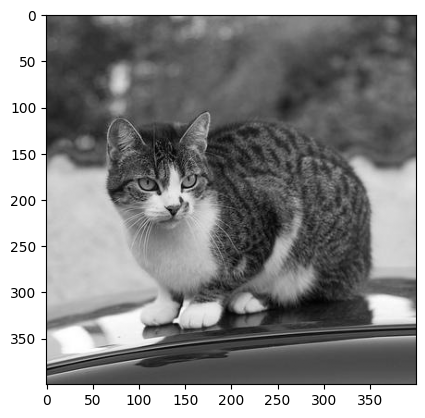

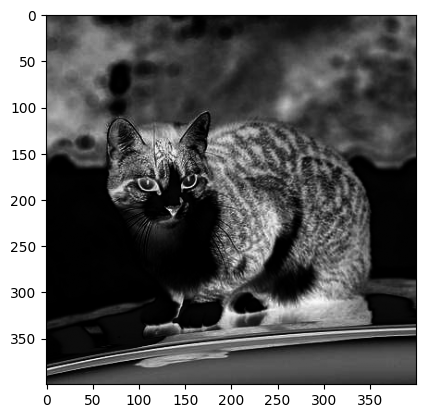

In [107]:
plt.imshow(x[0][1], cmap='gray')
plt.show()
plt.imshow(output[0][1].detach().numpy(), cmap='gray')
plt.show()

In [3]:
class SNI(nn.Module):
	'''
	https://github.com/AlanLi1997/rethinking-fpn
	soft nearest neighbor interpolation for up-sampling
	secondary features aligned
	'''
	def __init__(self, c1=0, c2=0, up_f=2):
		super(SNI, self).__init__()
		self.us = nn.Upsample(None, up_f, 'nearest')
		self.alpha = 1/(up_f**2)

	def forward(self, x):
		return self.alpha*self.us(x)


In [ ]:
class GSConvE(nn.Module):
	'''
	GSConv enhancement for representation learning: generate various receptive-fields and
	texture-features only in one Conv module
	https://github.com/AlanLi1997/slim-neck-by-gsconv
	'''
	def __init__(self, c1, c2, k=1, s=1, g=1, d=1, act=True):
		super().__init__()
		c_ = c2 // 2
		self.cv1 = Conv(c1, c_, k, s, None, g, d, act)
		self.cv2 = nn.Sequential(
			nn.Conv2d(c_, c_, 3, 1, 1, bias=False),
			nn.Conv2d(c_, c_, 3, 1, 1, groups=c_, bias=False),
			nn.GELU()
		)

	def forward(self, x):
		x1 = self.cv1(x)
		x2 = self.cv2(x1)
		y = torch.cat((x1, x2), dim=1)
		# shuffle
		y = y.reshape(y.shape[0], 2, y.shape[1] // 2, y.shape[2], y.shape[3])
		y = y.permute(0, 2, 1, 3, 4)
		return y.reshape(y.shape[0], -1, y.shape[3], y.shape[4])


In [4]:
# Bi-Former Block for fire and smoke detection
class BiFormerBlock(nn.Module):
	def __init__(self, embed_dim, num_heads, mlp_ratio=4.0, qkv_bias=False):
		super(BiFormerBlock, self).__init__()
		self.norm1 = nn.LayerNorm(embed_dim)
		self.attn = nn.MultiheadAttention(embed_dim, num_heads, batch_first=True)
		self.norm2 = nn.LayerNorm(embed_dim)
		self.mlp = nn.Sequential(
			nn.Linear(embed_dim, int(embed_dim * mlp_ratio)),
			nn.GELU(),
			nn.Linear(int(embed_dim * mlp_ratio), embed_dim),
		)

	def forward(self, x):
		x = self.norm1(x)
		x, _ = self.attn(x, x, x)
		x = x + self.mlp(self.norm2(x))
		return x



In [9]:
s = 1
for i in range(354, 365):
  s *= i/365

print((1-s)*1000, 3/4*1000)

167.0247888380646 750.0


Object `propositions` not found.


In [ ]:
yolo detect val model=runs/detect/train/weights/best.pt data=coco.yaml split=test plots=True
yolo detect train data=coco.yaml model=yolo11n.yaml epochs=100 imgsz=640 device=0,1,2,3 batch=128


In [ ]:
python path/to/yolov8 detect --source path/to/test/images --weights path/to/trained/weights --save-json

| Name| Epoch | PR mAP@0.5 | F1 score |
| ----------------- | ----------------- | ----------------- | ----------------- |
| Yolo11n-BRA-SN2 | 100 | 0.825 | 0.79 |
| Yolo11n-BRA-SN2 Pre-train | 100 | 0.855 | 0.81 |
| Yolo11n-BRA-SN2 | 300 | 0.843 | 0.79 |
| Yolo11n-BRA-SN2 Pre-train | 300 | 0.869 | 0.82 |
| Yolo11s-BRA-SN2 | 300 | 0.876 | 0.83 |
| Yolo11s-BRA-SN2 Pre-train | 300 | 0.877 | 0.85 |